In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# 1. Identifying Valid Participants, Converting Raw Filenames to Correct Naming Formats

In [31]:
import os
import shutil
from pathlib import Path
from typing import Iterable, List, Tuple, Dict
import importlib

from components import file_handling as fh
importlib.reload(fh)

# ===================================================
# IDENTIFICATION OF VALID PARTICIPANTS
# - Params: 
#   - `root_dir`: Directory path that contains all trial directories as immediate child folders.
#   - `expected_files`: List of filenames expected within each child folder
# - Returns:
#   - `valids`: list of directories that had all expected files
#   - `invalids`: list of directories that did not contain one or more expected files
def identify_valid_participants( root_dir:str, 
                                 expected_files:Iterable[str] ) -> Tuple[List[str], List[str]]:
    # Initialize paths
    root_path = Path(root_dir)
    expected = set(expected_files)

    # Initialize outputs
    with_all:List[str] = []
    missing:List[str] = []

    # Start iterating through all immediate subdirectories
    for subdir in root_path.iterdir():
        # Ignore if subdirectory is not a directory
        if not subdir.is_dir(): continue
        # Get present files in the subdirectory
        present = {p.name for p in subdir.iterdir() if p.is_file()}
        missing_files = sorted(expected - present)
        # Check if files are within subset of expected
        if expected.issubset(present):  with_all.append(str(subdir))
        else:                           missing.append((str(subdir), len(missing_files), missing_files))

    # Return both
    return with_all, missing

# COPY AND RENAME VALID PARTICIPANT FILES
# - Params:
#   - src_subdirs: a List of participant directories
#   - rename_map: a Dictionary dictating how to rename files
#   - dest_root: the parent directory where participant directories should be saved
# - Returns
#   - List of output participant directories
def copy_and_rename( src_subdirs: Iterable[str],
                     rename_map: Dict[str, str],
                     dest_root: str ) -> List[str]:

    # Initialize destination directory
    fh.mkdirs(dest_root)
    dest_root = Path(dest_root)

    # Initialize new subdirs list
    new_subdirs:List[str] = []

    # Iterate through existing source dirs
    for src in src_subdirs:
        # Prep copied dir
        src_dir = Path(src)
        dest_dir = dest_root / src_dir.name
        dest_dir.mkdir(parents=True, exist_ok=True)
        # Iterate through each file in each source directory
        for item in src_dir.iterdir():
            # Ignore any that are not files
            if not item.is_file(): continue
            # Remaps
            new_name = rename_map.get(item.name, item.name)
            dest_path = dest_dir / new_name
            # Copy
            shutil.copy2(item, dest_path)
        # save new output directory
        new_subdirs.append(str(dest_dir))
    # Return \
    return new_subdirs
# ===================================================

_RAWS_DIR = os.path.join('.', 'samples', 'raws')
_ROOT_DIR = os.path.join('.', 'samples', 'renamed')
_EXPECTED_FILES = {
    'calibration_test.csv':     'calibration_0.csv',
    'calibration_test_1.csv':   'calibration_1.csv',
    'calibration_test_2.csv':   'calibration_2.csv',
    'calibration_test_3.csv':   'calibration_3.csv',
    'calibration_test_4.csv':   'calibration_4.csv',
    'calibration_test_5.csv':   'calibration_5.csv',
    'calibration_test_6.csv':   'calibration_6.csv',
    'calibration_test_7.csv':   'calibration_7.csv',
    'eye.csv':                  'eye.csv',
    'eeg-rest.csv':             'eeg_rest.csv',
    'eeg-vr.csv':               'eeg_vr.csv',
    'pedestrians.csv':          'pedestrians.csv'
}
_TRIAL_NAMES = [
    "Trial-ApproachAudio Start", 
    "Trial-BehindAudio Start", 
    "Trial-Behind Start", 
    "Trial-AlleyRunnerAudio Start", 
    "Trial-AlleyRunner Start", 
    "Trial-Approach Start"
]

present, missing = prep_data(_RAWS_DIR, _EXPECTED_FILES.keys())
print("Present:")
for p in present: print(f'\t{p}')
print("Missing:")
for p in missing: print(f'\t{p}')

pdirs = copy_and_rename(present, _EXPECTED_FILES, _ROOT_DIR)
print("New Source Files:")
for p in pdirs: print(f'\t{p}')


Present:
	samples/raws/P3
	samples/raws/P2
	samples/raws/P5
	samples/raws/P4_Mus2
	samples/raws/P7
	samples/raws/P9
	samples/raws/P6
Missing:
	('samples/raws/PI1', 10, ['calibration_test.csv', 'calibration_test_1.csv', 'calibration_test_2.csv', 'calibration_test_3.csv', 'calibration_test_4.csv', 'calibration_test_5.csv', 'calibration_test_6.csv', 'calibration_test_7.csv', 'eeg-rest.csv', 'eeg-vr.csv'])
	('samples/raws/P10', 2, ['eeg-rest.csv', 'eeg-vr.csv'])
	('samples/raws/P0', 11, ['calibration_test.csv', 'calibration_test_1.csv', 'calibration_test_2.csv', 'calibration_test_3.csv', 'calibration_test_4.csv', 'calibration_test_5.csv', 'calibration_test_6.csv', 'calibration_test_7.csv', 'eeg-vr.csv', 'eye.csv', 'pedestrians.csv'])
	('samples/raws/PI2', 10, ['calibration_test.csv', 'calibration_test_1.csv', 'calibration_test_2.csv', 'calibration_test_3.csv', 'calibration_test_4.csv', 'calibration_test_5.csv', 'calibration_test_6.csv', 'calibration_test_7.csv', 'eeg-rest.csv', 'eeg-vr.csv

# 2. File Sorting into Trials

P6: 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]     


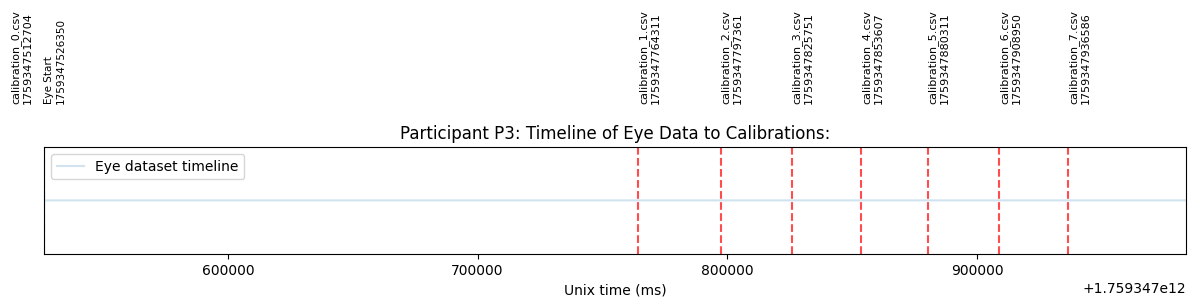

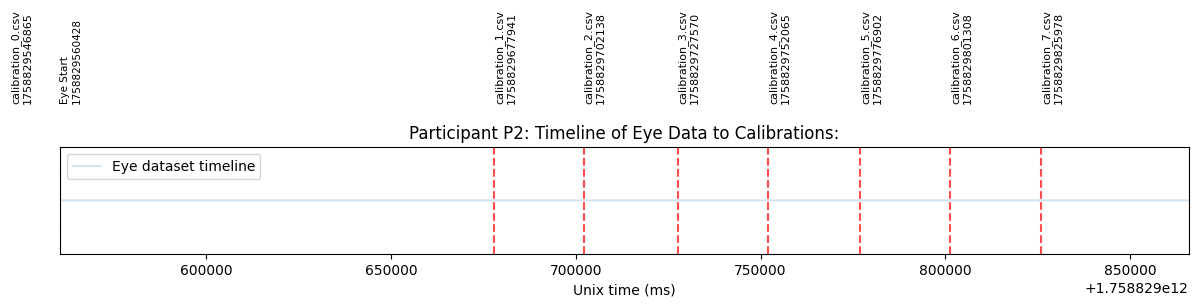

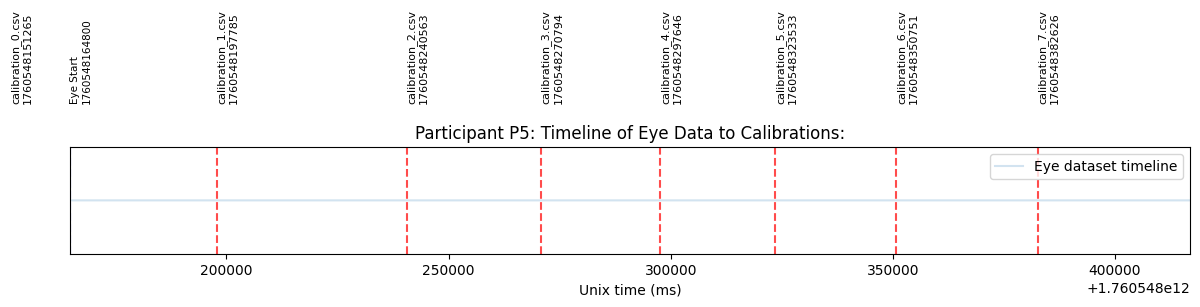

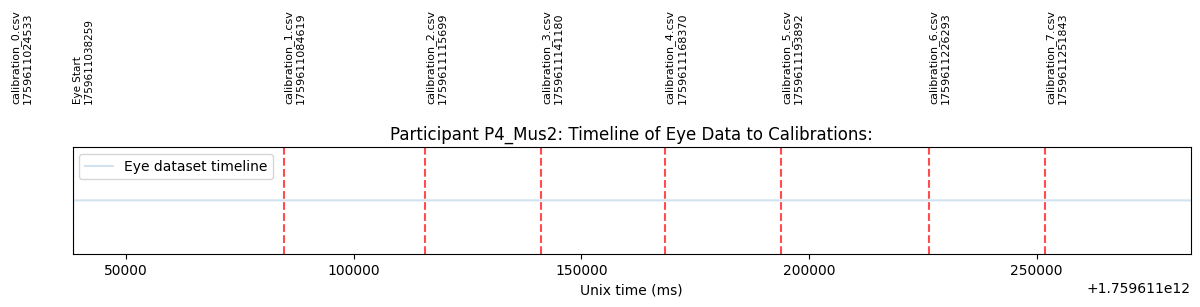

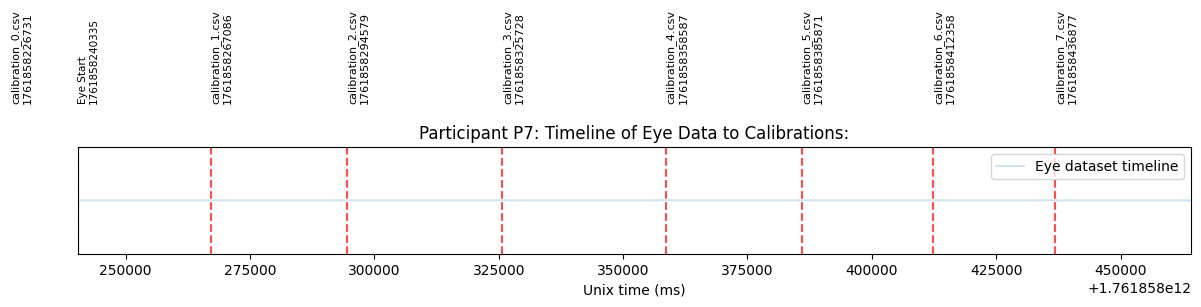

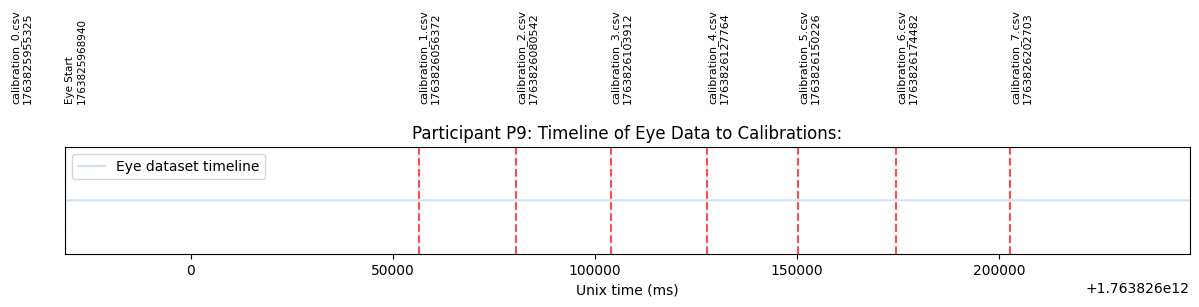

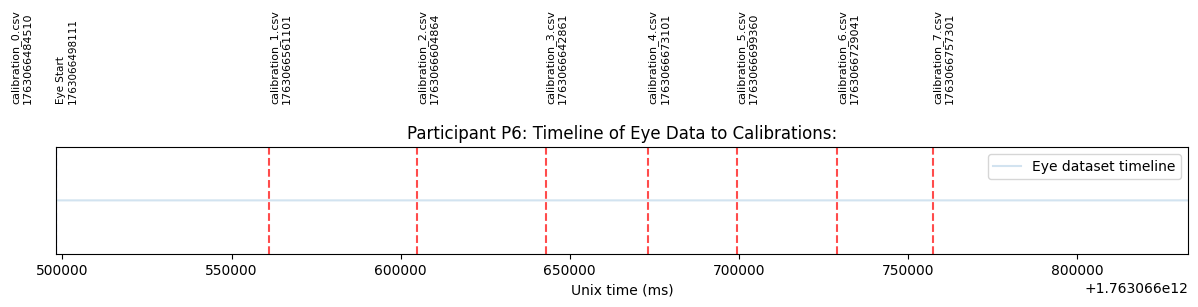

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
pd.options.mode.chained_assignment = None  # default='warn'

from components import eeg_handling as eh, plot_handling as ph
importlib.reload(eh)
importlib.reload(ph)

_CALIBRATION_COLUMNS = [
    'unix_ms', 
    'frame', 
    'rel_timestamp',
    'event', 
    'overlap_counter'
]

# 
def read_calibration_file(_F:str, correction:bool=True):
    # Read the file
    df = pd.read_csv(_F)

    # Correction, if necessary
    if correction: 
        df = df.iloc[:, :len(_CALIBRATION_COLUMNS)]
        df.columns = _CALIBRATION_COLUMNS

# SEPARATE FILES INTO TRIALS
def separate_into_trials( pdirs: Iterable[str] ) -> None:
    # Iterate through eahch participant directory
    pbar = tqdm(pdirs)
    for pdir in pbar:
        # Initialize Path and pbar, update pbar
        ppath = Path(pdir)
        pid = os.path.basename(pdir)
        pbar.set_description(pid)
        # Create the outpuyt directory for the rest state
        output_dir = fh.mkdirs(os.path.join(pdir, 'rest/'))
        # Read the eeg_rest data 
        eeg, blinks = eh.read(os.path.join(pdir, 'eeg_rest.csv'))
        raw, processed = eh.separate(eeg)
        #  Save rest data
        raw.to_csv(os.path.join(output_dir, 'raw.csv'), index=False)
        processed.to_csv(os.path.join(output_dir, 'processed.csv'), index=False)
        blinks.to_csv(os.path.join(output_dir, 'muse_blinks.csv'), index=False)

        # Render Eye-To-Calibration Files
        calibration_files = [str(cal_file) for cal_file in sorted(ppath.glob("calibration_*.csv"))]
        eye_file = os.path.join(pdir, 'eye.csv')
        ph.eye_calibration_timeline(
            pid, 
            eye_file, 
            calibration_files, 
            show = False,
            outpath = os.path.join(pdir, 'eye_to_cal_timeline.png')
        )
        



separate_into_trials(pdirs)